In [2]:
##IMPORTS
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import shapely
import skimage
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [3]:
class Preprocessing:
    def __init__(self, raster_path, vector_path, crs="EPSG:32651", pneo=False):
        self.raster_path = raster_path
        self.vector_path = vector_path
        self.crs = crs
        self.pneo = pneo

        self._rep_data = None
        self._rep_trans = None
        self._rep_crs = None

        self._clipped_data = None
        self._clipped_transform = None

    def reproject(self, target_crs="EPSG:32651", resampling=rasterio.enums.Resampling.nearest):
        if self.pneo:
            with rasterio.open(self.raster_path) as src:
                with rasterio.vrt.WarpedVRT(src, crs=target_crs, resampling=resampling) as vrt:
                    self._rep_data = vrt.read([1,2,3])
                    self._rep_trans = vrt.transform
                    self._rep_crs = vrt.crs
        else:
            with rasterio.open(self.raster_path) as src:
                with rasterio.vrt.WarpedVRT(src, crs=target_crs, resampling=rasterio.enums.Resampling.nearest) as vrt:
                    self._rep_data = vrt.read()
                    self._rep_trans = vrt.transform
                    self._rep_crs = vrt.crs

        return self._rep_data, self._rep_trans, self._rep_crs

    def clipraster(self, raster_data=None, transform=None, buffer_dist = 15, bbox = False):
        if raster_data is None:
            if self._rep_trans is None:
                raise ValueError("Reproject has not been performed. Call reproject() first.")
            else:
                raster_data = self._rep_data

        centerline = gpd.read_file(self.vector_path).to_crs(self.crs)

        buffered_lines = []
        for geometry in centerline.geometry:
            if isinstance(geometry, shapely.geometry.MultiLineString):
                for line in geometry.geoms:
                    buffered_lines.append(line.buffer(buffer_dist))
            elif isinstance(geometry, shapely.geometry.LineString):
                buffered_lines.append(geometry.buffer(buffer_dist))
            else:
                raise ValueError("Centerline not properly formatted") 

        buffered_lines_gdf = gpd.GeoDataFrame({"geometry": buffered_lines}, crs=self.crs)
    
        if bbox:
            bounding_box = buffered_lines_gdf.total_bounds
            bbox_polygon = shapely.geometry.box(*bounding_box)
            clipping_gdf = gpd.GeoDataFrame({"geometry": [bbox_polygon]}, crs=self.crs)
        else:
            clipping_gdf = buffered_lines_gdf

        clipping_geom = [geom.__geo_interface__ for geom in clipping_gdf.geometry]

        if transform is None:
            if self._rep_trans is None:
                raise ValueError("Reproject has not been performed. Call reproject() first.")
            else:
                transform = self._rep_trans #if transform not specified, use reprojected transform

        # Perform masking
        count = raster_data.shape[0] if len(raster_data.shape) == 3 else 1
        with rasterio.MemoryFile() as memfile:
            with memfile.open(
                driver="GTiff",
                height=raster_data.shape[-2],
                width=raster_data.shape[-1],
                count=count,
                dtype=raster_data.dtype,
                transform=transform,
                crs=self.crs,
            ) as dataset:
                if count == 1:
                    dataset.write(raster_data, 1)
                else:
                    for i in range(count):
                        dataset.write(raster_data[i], i + 1)

                # Debug masking
                try:
                    self._clipped_data, self._clipped_transform = mask(dataset, clipping_geom, crop=True)
                except ValueError as e:
                    print("Error during masking:", str(e))
                    raise

        return self._clipped_data, self._clipped_transform
    
    def display(self):
        if self._clipped_data is None:
            raise ValueError("Clipped data has not been generated. Call 'clipraster()' first.")
        else:
            data = self._clipped_data
            
        data = np.moveaxis(data, 0, -1)
        
        plt.imshow(data)
        plt.title(f"Clipped Image")
        plt.axis('off')
        plt.show()

class Filters:
    def __init__(self, raster_data, pneo=False):
        self.pneo = pneo
        self.raster_data = raster_data
        self._enhanced_warmth = None
        self._enhanced_stretched = None

    # @njit    
    def enhance_image_warmth(self):
        '''Enhances the warmth of an image's RGB bands'''

        if self.raster_data.dtype == np.uint16:
            raster_data = (self.raster_data / 65535.0 * 255).astype(np.uint8)
        
        else:
            raster_data = self.raster_data
            
        raster_data = np.moveaxis(raster_data, 0, -1) 
        enhanced_data = raster_data.copy()

        # Create masks for different conditions
        r = enhanced_data[:, :, 0]
        g = enhanced_data[:, :, 1]
        b = enhanced_data[:, :, 2]

        # Apply transformations for red channel
        r_mask_1 = (r < 30)
        r_mask_2 = (r >= 30) & (r < 100)
        r_mask_3 = (r >= 100) & (r < 175)
        r_mask_4 = (r >= 175) & (r < 255)

        r[r_mask_1] += 35
        r[r_mask_2] += 20
        r[r_mask_3] += 15
        r[r_mask_4] += 7

        # Apply transformations for green channel
        g_mask_1 = (g < 30)
        g_mask_2 = (g >= 30) & (g < 50)
        g_mask_3 = (g >= 50) & (g < 80)
        g_mask_4 = (g >= 80) & (g < 102)

        g[g_mask_1] += 30
        g[g_mask_2] += 20
        g[g_mask_3] += 15
        g[g_mask_4] = 90

        # Apply transformations for blue channel
        b_mask_1 = (b > 150)
        b_mask_2 = (b > 70) & (b <= 150)
        b_mask_3 = (b > 30) & (b <= 70)
        b_mask_4 = (b > 0) & (b <= 30)

        b[b_mask_1] -= 90
        b[b_mask_2] -= 40
        b[b_mask_3] -= 20
        b[b_mask_4] = 15

        # Update the enhanced_data array
        enhanced_data[:, :, 0] = r
        enhanced_data[:, :, 1] = g
        enhanced_data[:, :, 2] = b
        
        enhanced_data = (enhanced_data.astype(np.float32) / 255.0 * 65535).astype(np.uint16)
        enhanced_data = np.moveaxis(enhanced_data, -1, 0)
        self._enhanced_warmth = enhanced_data

        return self._enhanced_warmth
    
    def enhance_linear_stretch(self, lower_percent=98, upper_percent=100):
        """
        Apply linear stretching to enhance the image contrast.

        Parameters:
        - image: numpy array, the input raster image.
        - lower_percent: float, lower percentile to saturate.
        - upper_percent: float, upper percentile to saturate.

        Returns:
        - Stretched image as a numpy array.
        """
        if self.pneo:
            # lower, upper = 0, 100
            in_min = np.percentile(self.raster_data, lower_percent)
            in_max = np.percentile(self.raster_data, upper_percent)
            image = np.clip(self.raster_data, in_min, in_max)
            out_min, out_max = np.min(self.raster_data), np.max(self.raster_data)
            stretched_image = (image - in_min) / ((in_max - in_min) * (out_max - out_min))
            self._enhanced_stretched = stretched_image

        else:
            in_min = np.percentile(self.raster_data, lower_percent)
            in_max = np.percentile(self.raster_data, upper_percent)
            image = np.clip(self.raster_data, in_min, in_max)
            out_min, out_max = np.min(self.raster_data), np.max(self.raster_data)
            stretched_image = (image - in_min) / ((in_max - in_min) * (out_max - out_min))
            self._enhanced_stretched = stretched_image

        return self._enhanced_stretched
    
class Morph:
    def __init__(self, raster_data):
        self.raster_data = raster_data

        self._normalized = None
        self._edges = None
        self._thresholded = None
        self._merged = None
        self._morphed = None
        self._normalized_gray = None
    
    def normalize_band(self, band):
        return (band - band.min()) / (band.max() - band.min())

    # Normalize all bands
    def normalize_raster(self):
        self._normalized = (self.raster_data - self.raster_data.min()) / (self.raster_data.max() - self.raster_data.min())
        
        if self._normalized.shape[0] == 3:  # Convert to grayscale
            self.normalized_grayscale = skimage.color.rgb2gray(np.moveaxis(self._normalized, 0, -1))
            self._normalized_gray = self.normalized_grayscale
        else:
            self.normalized_grayscale = self._normalized[0]  #if single-band image
            self._normalized_gray = self.normalized_grayscale
            
    def detect_edge(self):
        self._edges = skimage.feature.canny(self.normalized_grayscale, sigma=1.4, low_threshold = 0.1, high_threshold = 0.5)
            
    def threshold_raster(self):
        otsu = skimage.filters.threshold_otsu(self.normalized_grayscale)
        self._thresholded = self.normalized_grayscale > otsu

    def merge(self):
        if self._edges is not None and self._thresholded is not None:
            self._merged = np.logical_and(self._edges, self._thresholded)
        else:
            raise ValueError("Edge detection or thresholding has not been performed yet.")

    def morphology(self, a=5, b=3):
        thresholded = self._thresholded.astype(np.uint8)

        kernel_a = np.ones((a, a), np.uint8)
        canny_dilated = cv2.dilate(self._edges.astype(np.uint8), kernel_a, iterations=3)

        kernel_b = np.ones((b,b), np.uint8)
        canny_eroded = cv2.erode(canny_dilated, kernel_b, iterations=7).astype(np.uint8)

        ##Merged_0: Merged (T+(T>D>E))
        self._morphed = np.logical_and(thresholded, canny_eroded) 

    def process(self):
        self.normalize_raster()
        self.detect_edge()
        self.threshold_raster()
        self.morphology()

        # return self._merged
        
    def display(self, data_type="morphed"):
        if data_type == "normalized":
            if self._normalized is None:
                raise ValueError("Normalized data has not been generated. Call `process()` first.")
            data = self._normalized
        elif data_type == "normalized_gray":
            if self._normalized_gray is None:
                 raise ValueError("Grayscale has not been performed. Call `process()` first.")
            data = self._normalized_gray
        elif data_type == "edges":
            if self._edges is None:
                raise ValueError("Edge detection has not been performed. Call `process()` first.")
            data = self._edges.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "thresholded":
            if self._thresholded is None:
                raise ValueError("Thresholding has not been performed. Call `process()` first.")
            data = self._thresholded.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "merged":
            if self._merged is None:
                raise ValueError("Merged result has not been created. Call `process()` first.")
            data = self._merged.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "morphed":
            if self._morphed is None:
                raise ValueError("Final result has not been created. Call `process()` first.")
            data = self._morphed.astype(np.uint8)  # Convert boolean to uint8
        else:
            raise ValueError(f"Invalid data_type: {data_type}. Choose from 'normalized', 'edges', 'thresholded', 'merged', 'morphed'.")
        
        data = data
        plt.imshow(data, cmap='gray')
        plt.title(f"{data_type}")
        plt.axis('off')
        plt.show()

    @property
    def normalized(self):
        if self._normalized is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._normalized

    @property
    def edges(self):
        if self._edges is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._edges

    @property
    def thresholded(self):
        if self._thresholded is None:
            raise ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._thresholded

    @property
    def merged(self):
        if self._merged is None:
            ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._merged

    @property  
    def output(self):
        if self._morphed is None:
            ValueError("Normalization has not been performed. Call the `process()` method first.")
        return self._morphed

    def export(self, output_path, data_type="merged", transform=None, crs=None):

        """
        Export the specified processed raster to a GeoTIFF file.
    
        Args:
            output_path (str): Path to save the GeoTIFF file.
            data_type (str): Type of data to export ('normalized', 'edges', 'thresholded', 'merged').
            transform (affine.Affine): Affine transform for the raster. Defaults to `None`.
            crs (dict or str): CRS of the raster. Defaults to `None`.
        """
        output_folder = os.path.dirname(output_path)
        if not os.path.exists(output_folder):       #create folder if it doesn't exist
            os.makedirs(output_folder)

        # Select the appropriate data based on `data_type`
        if data_type == "normalized":
            if self._normalized is None:
                raise ValueError("Normalized data has not been generated. Call `process()` first.")
            data = self._normalized
        elif data_type == "edges":
            if self._edges is None:
                raise ValueError("Edge detection has not been performed. Call `process()` first.")
            data = self._edges.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "thresholded":
            if self._thresholded is None:
                raise ValueError("Thresholding has not been performed. Call `process()` first.")
            data = self._thresholded.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "merged":
            if self._merged is None:
                raise ValueError("Merged result has not been created. Call `process()` first.")
            data = self._merged.astype(np.uint8)  # Convert boolean to uint8
        elif data_type == "morphed":
            if self._morphed is None:
                raise ValueError("Final result has not been created. Call `process()` first.")
            data = self._morphed.astype(np.uint8)  # Convert boolean to uint8
        else:
            raise ValueError(f"Invalid data_type: {data_type}. Choose from 'normalized', 'edges', 'thresholded', 'merged', 'morphed'.")
    
        # Ensure transform and CRS are provided
        if transform is None or crs is None:
            raise ValueError("Both `transform` and `crs` must be provided for export.")
    
        # Write the raster to a GeoTIFF file
        with rasterio.open(
            output_path,
            "w",
            driver="GTiff",
            height=data.shape[0],
            width=data.shape[1],
            count=1,
            dtype=data.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(data, 1)
            
        basename = os.path.basename(output_path)
        return print(f"Successfully saved {basename} to {output_path}")

class MeasureWidth:
    def __init__(self, raster_data, raster_transform, centerline_path, raster_crs="EPSG:32651"):
        self.raster_data = raster_data
        self.transform = raster_transform
        self.crs = raster_crs
        self.centerline = gpd.read_file(centerline_path)
        self.vectorized_roads = None
        self._transects = None
        self.clipped_transects = None
        
    def create_transects(self, transect_length=10, interval=10):
        """Create transects perpendicular to a centerline at regular intervals."""
        self.centerline = self.centerline.to_crs(self.crs)
        self.centerline = self.centerline.geometry[0]
        
        transects = []
        for i in range(0, int(self.centerline.length), interval):
            point = self.centerline.interpolate(i)
            next_point = self.centerline.interpolate(i + 1)

            # Convert tuples to numpy arrays and ensure they are 2D (x, y)
            point_coords = np.array(point.coords[0][:2])
            next_point_coords = np.array(next_point.coords[0][:2])

            normal = next_point_coords - point_coords
            normal = np.array([-normal[1], normal[0]])  # Rotate 90 degrees to get normal vector
            normal = normal / np.linalg.norm(normal) # Normalize the vector
            
            transect_start = point_coords + normal * -transect_length  # Extend 10 meters on one side
            transect_end = point_coords + normal * transect_length  # Extend 10 meters on the other side

            transects.append(shapely.geometry.LineString([transect_start, transect_end]))

        self._transects = gpd.GeoDataFrame(geometry=transects, crs=self.crs)
        return self._transects

    def vectorize_roads(self, smooth=True, tolerance=None):
        """Vectorize the road areas (where raster value is 1) and optionally smooth the edges."""
        # Mask out non-road areas
        road_mask = self.raster_data == 1
        if np.sum(road_mask) == 0:
            print("No roads found in the raster data.")
            return None  # No roads to vectorize

        # Vectorize the road mask using rasterio.features.shapes
        shapes_generator = rasterio.features.shapes(self.raster_data, mask=road_mask, transform=self.transform)
    
        # Create GeoDataFrame from vectorized shapes
        if tolerance is None:
            tolerance = 1.0

        geometries = []
        for geom, value in shapes_generator:
            if value == 1:  # Only keep the shapes with value 1 (road areas)
                geom_shape = shapely.geometry.shape(geom)
                # Apply smoothing if enabled
                if smooth:
                    geom_shape = geom_shape.buffer(tolerance).simplify(tolerance)
                geometries.append(geom_shape)
        
        if len(geometries) == 0:
            print("No vectorized roads found.")
            return None  # No geometries were created
        
        # Create a GeoDataFrame to store the vectorized roads
        self.vectorized_roads = gpd.GeoDataFrame(geometry=geometries, crs=self.crs)
        return self.vectorized_roads

    def clip_transects(self):
        """Clip transects using the vectorized roads and save the result."""
        if self.vectorized_roads is None:
            raise ValueError("Roads not vectorized. Run vectorize_roads() first.")

        # Clip transects with the vectorized roads
        clipped = gpd.overlay(self._transects, self.vectorized_roads, how='intersection')

        self.clipped_transects = clipped

    def clip_transects(self):
        """Clip transects using the vectorized roads and save the result."""
        if self.vectorized_roads is None:
            raise ValueError("Roads not vectorized. Run vectorize_roads() first.")

        # Clip transects with the vectorized roads
        clipped = gpd.overlay(self._transects, self.vectorized_roads, how='intersection')
        
        self.clipped_transects = clipped
        self.clipped_transects['width'] = clipped.geometry.length

        return self.clipped_transects[['geometry', 'width']]
    
    def filter_transects(self):
        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run clip_transects() first.")
        
        self.clipped_transects = self.clipped_transects[(self.clipped_transects["width"] >= 4) & (self.clipped_transects["width"] <= 8)]

    def process(self, tolerance=None):
        self.create_transects()
        self.vectorize_roads(tolerance=tolerance)
        self.clip_transects()
        self.filter_transects()
        return self.clipped_transects[['geometry', 'width']]

    def export(self, output_path):
         # Ensure the output folder exists
        output_folder = os.path.dirname(output_path)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run process() first.")

        self.clipped_transects.to_file(output_path, crs=self.crs)

        return print(f"Road width exported successfully to {output_path}")
    
    @property
    def vectorized(self):
        if self.vectorized_roads is None:
            raise ValueError("Road not vectorized. Run process() first.")
        return self.vectorized_roads
    
    @property
    def transects(self):
        if self.clipped_transects is None:
            raise ValueError("Transects not measured. Run process() first.")
        
        return self.clipped_transects
    
def export(raster, transform, output_path, crs="EPSG: 32651"):
    # Ensure output folder exists
    output_folder = os.path.dirname(output_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    with rasterio.open(
            output_path,
            "w",
            driver="GTiff",
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=raster.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(raster, 1)
            
    basename = os.path.basename(output_path)
    return print(f"Successfully saved {basename} to {output_path}")

In [4]:
def normalize(raster_data):
    #normalize PNEO data to [0, 1]
    normalized = (raster_data - raster_data.min()) / (raster_data.max() - raster_data.min())

    #create grays image for canny and otsu
    if normalized.shape[0] == 4 or normalized.shape[0] == 3:
        normalized_gray = skimage.color.rgb2gray(np.moveaxis(normalized, 0, -1))
    else:
        normalized_gray = normalized[0]

    return normalized, normalized_gray

def get_edges(raster_data, sigma, low, high): #raster_data = gray
    raster_edge = skimage.feature.canny(raster_data, sigma = sigma, low_threshold=low, high_threshold=high) #sigma = , low_threshold = , high_threshold = 

    return raster_edge

def get_threshold(raster_data):
    otsu = skimage.filters.threshold_otsu(raster_data)
    thresholded = raster_data > otsu
    return thresholded

def morphology(threshold, canny, a=5, b=3, iter=(3,3)):
        iter_dil, iter_ero = iter
        thresholded = threshold.astype(np.uint8)

        kernel_a = np.ones((a, a), np.uint8)
        canny_dilated = cv2.dilate(canny.astype(np.uint8), kernel_a, iterations=iter_dil)

        kernel_b = np.ones((b,b), np.uint8)
        canny_eroded = cv2.erode(canny_dilated, kernel_b, iterations=iter_ero).astype(np.uint8)

        ##Merged_0: Merged (T+(T>D>E))
        morphed = np.logical_and(thresholded, canny_eroded)
        
        return morphed

In [5]:
#preprocessing
raster_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 20\FMR20-PANSHARPENED.tif"
vector_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_05315915405614\FMR 20\FMR20_PNEO_CL.shp"

dirname = os.path.dirname(raster_path)
basename = os.path.basename(dirname)

preprocessor = Preprocessing(raster_path, vector_path, pneo=True)
preprocessor.reproject()
clipped_data, clipped_transform = preprocessor.clipraster() #bbox=False
print(f"Shape of clipped data: {clipped_data.shape}" )

# Filters: warmth and linear stretch
filter = Filters(clipped_data)
warm_raster = filter.enhance_image_warmth()
stretch_raster = filter.enhance_linear_stretch()
print("Applying filter completed.")

RasterioIOError: C:/Users/user-307E4B3400/OneDrive - Philippine Space Agency/SDMAD_SHARED/PROJECTS/SAKA/FMR/PNEO FMR/.PANSHARPENED/PNEOHD4_05315915405614/FMR 20/FMR20-PANSHARPENED.tif: No such file or directory

In [5]:
def normalized_difference(band1, band2):
    return (band1 - band2) / (band1 + band2)

def SAVI(nir, red, L=0.5):
    return ((nir - red) / (nir + red + L)) * (1 + L)

def EVI(nir, red, blue, G=2.5, C1=6, C2=7.5, L=1):
    return G * (nir - red) / (nir + C1 * red - C2 * blue + L)

def BI(nir, red, blue):
    return (nir + red) - blue

raster = rasterio.open(raster_path)
red = raster.read(1)
green = raster.read(2)
blue = raster.read(3)
nir = raster.read(4)

(-0.5, 9667.5, 4843.5, -0.5)

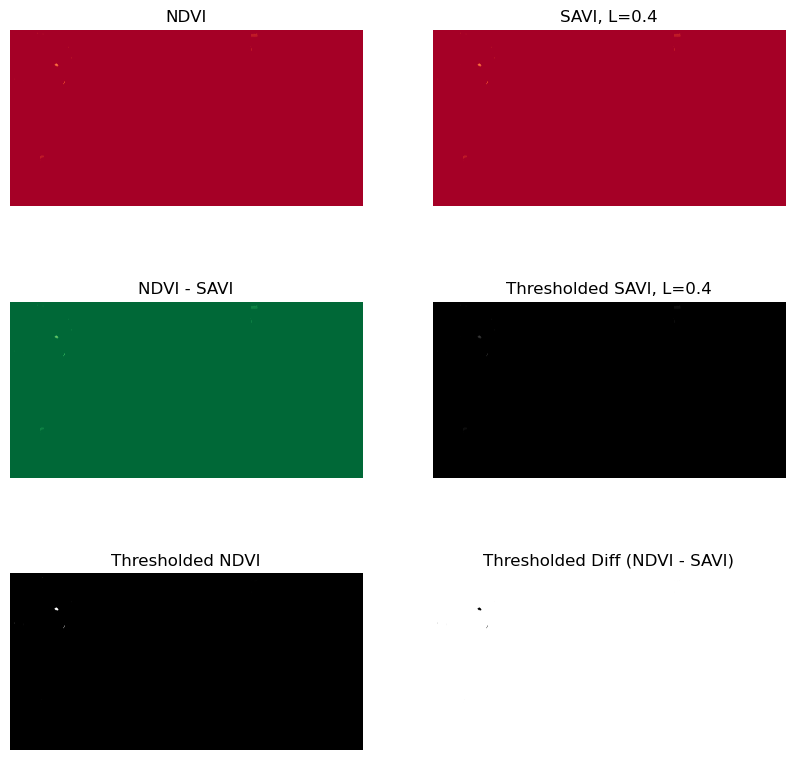

In [6]:
#INDICES

ndvi = normalized_difference(nir, red)
L = 0.4
savi = SAVI(nir, red,  L=L)
# evi = EVI(nir, red, blue)
bi = BI(nir, red, blue)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ndvi, cmap='RdYlGn')
ax[0].set_title("NDVI")
ax[0].axis("off")

ax[1].imshow(savi, cmap='RdYlGn')
ax[1].set_title(f"SAVI, L={L}")
ax[1].axis("off")

difference = ndvi-savi

ax[2].imshow(difference, cmap='RdYlGn')
ax[2].set_title("NDVI - SAVI")
ax[2].axis("off")

thresh_SAVI = get_threshold(savi)
thresh_ndvi = get_threshold(ndvi)
thresh_diff = get_threshold(difference)

ax[3].imshow(savi, cmap='gray')
ax[3].set_title(f"Thresholded SAVI, L={L}")
ax[3].axis("off")

ax[4].imshow(thresh_ndvi, cmap='gray')
ax[4].set_title("Thresholded NDVI")
ax[4].axis("off")

ax[5].imshow(thresh_diff, cmap='gray')
ax[5].set_title("Thresholded Diff (NDVI - SAVI)")
ax[5].axis("off")

In [ ]:
output_path = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\PNEO FMR\.PANSHARPENED\PNEOHD4_202501230237466\FMR20"
export(savi, raster.transform, os.path.join(output_path, os.path.basename(output_path) + "_SAVI.tif"), crs=raster.crs)
export(bi, raster.transform, os.path.join(output_path, os.path.basename(output_path) + "_BI.tif"), crs=raster.crs)
export(difference, raster.transform, os.path.join(output_path, os.path.basename(output_path) + "_NDVI-SAVI.tif"), crs=raster.crs)

In [8]:
raster = rasterio.open(raster_path)

raster_nirRB = raster.read([4, 1, 3])
raster_nirRG = raster.read([4, 1, 2])

#Apply filter
raster_nirRB, clipped_transform = preprocessor.clipraster(raster_nirRB, transform=raster.transform)
filter_nirRB = Filters(raster_nirRB)
stretch_nirRB = filter_nirRB.enhance_linear_stretch()

raster_nirRG, clipped_transform = preprocessor.clipraster(raster_nirRG, transform=raster.transform)
filter_nirRG = Filters(raster_nirRG)
stretch_nirRG = filter_nirRG.enhance_linear_stretch()
print("Applying filter completed.")

raster_nirRB, gray_nirRB = normalize(stretch_nirRB) #normalized
raster_nirRG, gray_nirRG = normalize(stretch_nirRG) #normalized

Applying filter completed.


(-0.5, 9363.5, 3395.5, -0.5)

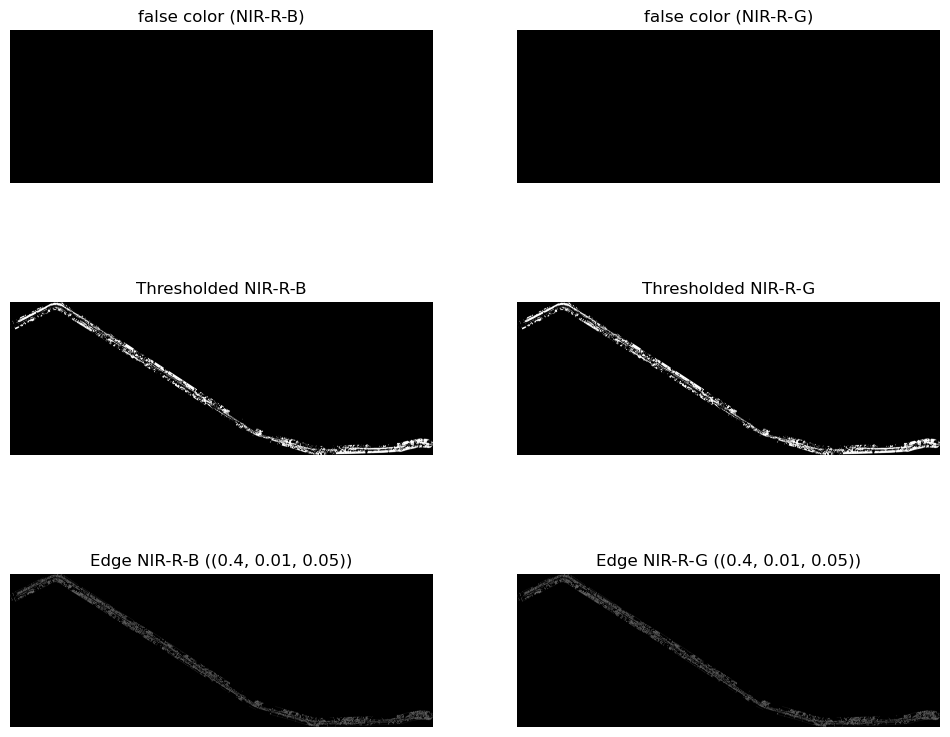

In [9]:
#false color
raster_nirRB, gray_nirRB = normalize(raster_nirRB) #normalized
raster_nirRG, gray_nirRG = normalize(raster_nirRG) #normalized

fig, axes = plt.subplots(3, 2, figsize=(12,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(np.moveaxis(raster_nirRB, 0, -1).astype(np.uint8))
ax[0].set_title("false color (NIR-R-B)")
ax[0].axis("off")

ax[1].imshow(np.moveaxis(raster_nirRG, 0, -1).astype(np.uint8))
ax[1].set_title("false color (NIR-R-G)")
ax[1].axis("off")

thresh_nirRB = get_threshold(gray_nirRB)
thresh_nirRG = get_threshold(gray_nirRG)
# thresh_ndvi = get_threshold(ndvi)

ax[2].imshow(thresh_nirRB, cmap='gray')
ax[2].set_title("Thresholded NIR-R-B")
ax[2].axis("off")

ax[3].imshow(thresh_nirRG, cmap='gray')
ax[3].set_title("Thresholded NIR-R-G")
ax[3].axis("off")

sigma, low, high = 0.4, 0.01, 0.05
edge_nirRB = get_edges(gray_nirRB, sigma=sigma, low=low, high=high)
edge_nirRG = get_edges(gray_nirRG, sigma=sigma, low=low, high=high)

ax[4].imshow(edge_nirRB, cmap='gray')
ax[4].set_title(f"Edge NIR-R-B ({sigma, low, high})")
ax[4].axis("off")

ax[5].imshow(edge_nirRG, cmap='gray')
ax[5].set_title(f"Edge NIR-R-G ({sigma, low, high})")
ax[5].axis("off")

In [28]:
preprocessor = Preprocessing(raster_path, vector_path, pneo=True)

clipped_nirRB, transform = preprocessor.clipraster(thresh_nirRB.astype(np.uint8), transform=raster.transform, buffer_dist=3)
clipped_nirRG, transform = preprocessor.clipraster(thresh_nirRG.astype(np.uint8), transform=raster.transform, buffer_dist=3)

final_nirRB = np.squeeze(clipped_nirRB)
final_nirRG = np.squeeze(clipped_nirRG)

final_nirRB = cv2.morphologyEx(final_nirRB.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=4)
final_nirRG = cv2.morphologyEx(final_nirRG.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=4)

# plt.imshow(final_nirRB, cmap="gray")
# plt.axis("off")
# plt.title("Clipped nirRB")
# plt.show()

# plt.imshow(final_nirRG, cmap="gray")
# plt.axis("off")
# plt.title("Clipped nirRG")
# plt.show()

measure_nirRB = MeasureWidth(final_nirRB, transform, vector_path)
measure_nirRG = MeasureWidth(final_nirRG, transform, vector_path)
tol = 0.30

measure_nirRB.process(tolerance=tol)
measure_nirRG.process(tolerance=tol)

output_folder = r"C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]"
export(final_nirRB, transform, os.path.join(output_folder, basename, basename + "-final-road_nirRB-stretch.tif") )
export(final_nirRG, transform, os.path.join(output_folder, basename, basename + "-final-road_nirRG-stretch.tif"))

measure_nirRB.export(os.path.join(output_folder, basename, basename + f"-final-widths_tol_{tol}-nirRB-stretch.geojson"))
print("Width extraction completed.")
print("NIR-R-B:", measure_nirRB.transects)

measure_nirRG.export(os.path.join(output_folder, basename, basename + f"-final-widths_tol_{tol}-nirRG-stretch.geojson"))
print("Width extraction completed.")
print("NIR-R-G:", measure_nirRG.transects)




Successfully saved FMR20-final-road_nirRB-stretch.tif to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\FMR20\FMR20-final-road_nirRB-stretch.tif
Successfully saved FMR20-final-road_nirRG-stretch.tif to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\FMR20\FMR20-final-road_nirRG-stretch.tif
Road width exported successfully to C:\Users\user-307E4B3400\OneDrive - Philippine Space Agency\SDMAD_SHARED\PROJECTS\SAKA\FMR\Road Width [INITIAL]\FMR20\FMR20-final-widths_tol_0.3-nirRB-stretch.geojson
Width extraction completed.
NIR-R-B:                                               geometry     width
0    LINESTRING (267065.050 1740310.948, 267071.377...  6.475760
4    LINESTRING (267052.243 1740252.331, 267058.360...  6.259316
5    LINESTRING (267048.293 1740232.723, 267053.998...  5.838192
9    LINESTRING (267039.449 1740193.711, 267045.355...  6.043729
11   LINESTRING